In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

In [48]:
import numpy as np
import pandas as pd
import sys # 최대정수

from tensorflow.keras.utils import to_categorical # 분류분석시 y데이터 원핫인코딩
from tensorflow.keras.models import Sequential # 모델 객체 생성
from tensorflow.keras.layers import Input, Dense, Dropout # 모델 layer 쌓을 때 필요. 과적합시 필요
from tensorflow.keras.models import save_model, load_model # 모델 저장, 로드
from tensorflow.keras.optimizers import Adam # optimizer='adam'의 learning rate 조절가능
from tensorflow.keras.metrics import Recall, Precision # accuracy 외에 정밀도, 재현율 설정

from sklearn.preprocessing import StandardScaler, MinMaxScaler # 정규화, 표준화
from sklearn.metrics import confusion_matrix # 혼동행렬, 교차표
from sklearn.model_selection import train_test_split # 데이터 분리

import matplotlib.pyplot as plt

# 이진분류(로지스틱 회귀분석)

- 1. 데이터 셋 생성 & 전처리
    - 엑셀 → 데이터프레임 → ? 처리(결측치로 전환하여 결측치처리 - 지우기/대체) → x,y분리<br> → X변수의 scale조정(y는 1,0이라 필요없음) → train_test_split()를 이용하여 학습셋과 테스트셋 분리
- 2. 모델생성(입력 13개, 출력 1개) & 학습과정 설정 & 학습
- 3. 모델평가(그래프, 평가, 혼동행렬 == 교차표)
- 4. 모델사용/저장

In [ ]:
'''
age 나이 (세)
sex 성별
    1 : 남성
    0 : 여성
cp (chest pain type) 가슴 통증(흉통) 타입
    1 : typical angina (전형적 협심증)
    2 : atypical angina (비전형적 협심증)
    3 : non-anginal pain (심장 관련이 아닌 흉통)
    4 : asymptomatic (증상 없음)
treshtbps (resting blood pressure) 안정 시 수축기 혈압 (mm Hg)
    병원 처음 내원했을 때 잰 혈압이라고 보면 됨
chol (serum cholesterol) 혈청 콜레스테롤 수치 (mg/dl)
    여기 보니까 ?가 있어서, 일부 결측값이 문자로 들어가 있는 상태야
fbs (fasting blood sugar) 공복 혈당 > 120 mg/dl 여부
    1 : 공복 혈당 120 초과 (고혈당)
    0 : 아니면 0
restecg (resting electrocardiographic results) 안정시 심전도 결과
    0 : 정상
    1 : ST-T wave 이상 (ST-T 파 이상, T wave 반전 등)
    2 : LVH 가능성 (좌심실 비대 소견 등)
thalach (maximum heart rate achieved) 운동 검사에서 기록된 최대 심박수
exang (exercise induced angina) 운동으로 유발된 협심증 여부
    1 : 운동 시 흉통 있음
    0 : 없음
oldpeak 운동으로 인해 발생한 ST 절 하강 정도 (depression)
    숫자가 클수록 보통 심장 허혈 가능성↑로 봄
slope (slope of peak exercise ST segment) 운동 시 ST 세그먼트 기울기
    1 : upsloping (상승형)
    2 : flat (평평)
    3 : downsloping (하강형)
ca 조영제(조영술)에서 보이는 주요 관상동맥 수 (0~3)
    0이면 문제 있는 관상동맥이 없는 것, 
    숫자가 클수록 문제 있는 혈관 수가 많다고 보면 됨
    여기에도 ? 값 좀 섞여 있음
hsl (보통 다른 데이터셋에서는 thal) 아마 **thalassemia 관련 검사 결과(thal)**를 의미
    3 : normal
    6 : fixed defect (고정 결손)
    7 : reversible defect (가역 결손)
    여기도 숫자가 이런 패턴이라, 같은 의미로 봐도 될 듯
heartDisease (target) 심장질환 유무 (목표 변수)
'''

## 1. 데이터 셋 생성 & 전처리

- 엑셀 → 데이터프레임 → ? 처리(결측치로 전환하여 결측치처리 - 지우기/대체) → x,y분리<br> → X변수의 scale조정(y는 1,0이라 필요없음) → train_test_split()를 이용하여 학습셋과 테스트셋 분리

In [11]:
# 아나콘다 프롬프트에서 ml-dl-nlp 가상환경(conda activate ml-dl-nlp)으로 간 후 pip install openpyxl

df = pd.read_excel('data/heart-disease.xlsx') # 시트가 여려개일 경우 sheet_name='' 에 시트이름 써주기
df.info() # object 있는 놈들이 수상함. 거기에 ?로 결측치가 있음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          303 non-null    object 
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            303 non-null    object 
 12  hsl           303 non-null    object 
 13  heartDisease  303 non-null    int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 33.3+ KB


In [12]:
df.isna().sum()

age             0
sex             0
cp              0
treshtbps       0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              0
hsl             0
heartDisease    0
dtype: int64

In [14]:
df.isin(['?']).sum() # ?(결측치)가 몇개 있는지 확인

age             0
sex             0
cp              0
treshtbps       0
chol            1
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              4
hsl             2
heartDisease    0
dtype: int64

In [19]:
# '?'가 포함된 데이터 추출 (chol, ca, hsl) : 7행

# df[df['chol'].isin(['?'])]
df[(df['chol']=='?') | (df['ca']=='?') | (df['hsl']=='?')]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1
87,53,0,3,128,216,0,2,115,0,0.0,1,0,?,0
166,52,1,3,138,223,0,0,169,0,0.0,1,?,3,0
192,43,1,4,132,247,1,2,143,1,0.1,2,?,7,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0,?,1
287,58,1,2,125,220,0,0,144,0,0.4,2,?,7,0
302,38,1,3,138,175,0,0,173,0,0.0,1,?,3,0


In [22]:
# ?를 결측치(np.nan)로 대체 → 결측치 처리(삭제)

df.replace('?', np.nan, inplace=True)
df[(df['chol']=='?') | (df['ca']=='?') | (df['hsl']=='?')]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease


In [23]:
df.isna().sum()

age             0
sex             0
cp              0
treshtbps       0
chol            1
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              4
hsl             2
heartDisease    0
dtype: int64

In [25]:
# 결측치가 포함된 데이터 추출

df[df.isna().any(axis=1)] # 결측치가 하나라도 포함된 행 True로 걸림

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,NaN,0,2,129,1,2.6,2,2.0,7.0,1
87,53,0,3,128,216.0,0,2,115,0,0.0,1,0.0,NaN,0
166,52,1,3,138,223.0,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247.0,1,2,143,1,0.1,2,NaN,7.0,1
266,52,1,4,128,204.0,1,0,156,1,1.0,2,0.0,NaN,1
287,58,1,2,125,220.0,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175.0,0,0,173,0,0.0,1,NaN,3.0,0


In [27]:
# 결측치 처리: 대체(fillna) / 삭제(dropna)

df = df.dropna(how='any') # 결측치에 한열이라도 있으면 삭제. 기본값 'any'. 'all'은 모든열이 결측치인행 삭제
df.isna().sum()

age             0
sex             0
cp              0
treshtbps       0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              0
hsl             0
heartDisease    0
dtype: int64

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296 entries, 0 to 301
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           296 non-null    int64  
 1   sex           296 non-null    int64  
 2   cp            296 non-null    int64  
 3   treshtbps     296 non-null    int64  
 4   chol          296 non-null    float64
 5   fbs           296 non-null    int64  
 6   restecg       296 non-null    int64  
 7   thalach       296 non-null    int64  
 8   exang         296 non-null    int64  
 9   oldpeak       296 non-null    float64
 10  slope         296 non-null    int64  
 11  ca            296 non-null    float64
 12  hsl           296 non-null    float64
 13  heartDisease  296 non-null    int64  
dtypes: float64(4), int64(10)
memory usage: 34.7 KB


In [32]:
# target변수의 분포가 균형을 이루는지지

df['heartDisease'].value_counts() / df.shape[0]*100

0    54.054054
1    45.945946
Name: heartDisease, dtype: float64

In [34]:
# 입력(독립)변수와 타겟(종속, 출력)변수 분리

X = df.iloc[:, :-1].values # 맨 마지막 열을 제외한 부분을 numpy배열
y = df.iloc[:, -1:].values # 2차원으로 넣기 위해 -1: 을 굳이 붙여줌 (train_test_split을 사용하기 위해서)

X.shape, y.shape

((296, 13), (296, 1))

In [35]:
X[0]

array([ 63. ,   1. ,   1. , 145. , 233. ,   1. ,   2. , 150. ,   0. ,
         2.3,   3. ,   0. ,   6. ])

In [37]:
# 입력변수 X의 스케일 조정

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
scaled_X[0]

array([0.70833333, 1.        , 0.        , 0.48113208, 0.24429224,
       1.        , 1.        , 0.60305344, 0.        , 0.37096774,
       1.        , 0.        , 0.75      ])

In [38]:
# scaled_X, y를 학습데이터셋 : 테스트데이터셋 = 7:3으로 분할

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                    test_size=0.3,  # 테스트셋의 비율. 기본 0.25
                                                    random_state=7, # 시드값 맞추기
                                                    )

In [43]:
# 심장병 음성/양성 비율

# 전체 데이터 비율
print(pd.DataFrame(y).value_counts(normalize=True)*100)

# 테스트 데이터 비율
print(pd.DataFrame(y_train).value_counts(normalize=True)*100)
print(pd.DataFrame(y_test).value_counts(normalize=True)*100)

0    54.054054
1    45.945946
dtype: float64
0    51.690821
1    48.309179
dtype: float64
0    59.550562
1    40.449438
dtype: float64


In [44]:
# scaled_X, y를 학습데이터셋 : 테스트데이터셋 = 7:3으로 분할

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                    test_size=0.3,  # 테스트셋의 비율. 기본 0.25
                                                    random_state=7, # 시드값 맞추기
                                                    stratify=y) # 층화추출. y의 0,1기준으로 나눔

In [45]:
# 심장병 음성/양성 비율

# 전체 데이터 비율
print(pd.DataFrame(y).value_counts(normalize=True)*100)

# 테스트 데이터 비율
print(pd.DataFrame(y_train).value_counts(normalize=True)*100)
print(pd.DataFrame(y_test).value_counts(normalize=True)*100)

0    54.054054
1    45.945946
dtype: float64
0    54.10628
1    45.89372
dtype: float64
0    53.932584
1    46.067416
dtype: float64


## 2. 모델 생성(입력 13개, 출력1개) & 학습과정 설정 & 학습

- 모델 : 13 → 32 → 16 → 8 → 1
- 그래프를 보고 과적합이 심하면 줄이기를 추가할 수 있음

In [70]:
model = Sequential()
model.add(Input(shape=(13,)))
model.add(Dense(units=32, activation='tanh'))
model.add(Dropout(0.1)) # 10% 데이터 날리기
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 32)                448       
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_21 (Dense)            (None, 16)                528       
                                                                 
 dropout_13 (Dropout)        (None, 16)                0         
                                                                 
 dense_22 (Dense)            (None, 8)                 136       
                                                                 
 dropout_14 (Dropout)        (None, 8)                 0         
                                                                 
 dense_23 (Dense)            (None, 1)                

In [71]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',  # 정확도
                                                                     Precision(), # 정밀도(예측값 중심)
                                                                     Recall()])   # 재현율(실제값 중심)

In [72]:
%%time
hist = model.fit(X_train, y_train,     # 훈련데이터셋
                 epochs=200,           # 학습횟수
                 validation_split=0.2, # 검증데이터를 훈련데이터의 20%로 사용
                 verbose=0)            # 간단 로그출력

CPU times: total: 15.4 s
Wall time: 11.8 s


## 3. 모델평가(그래프, 평가, 교차표) 

In [76]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision_5', 'recall_5', 'val_loss', 'val_accuracy', 'val_precision_5', 'val_recall_5'])

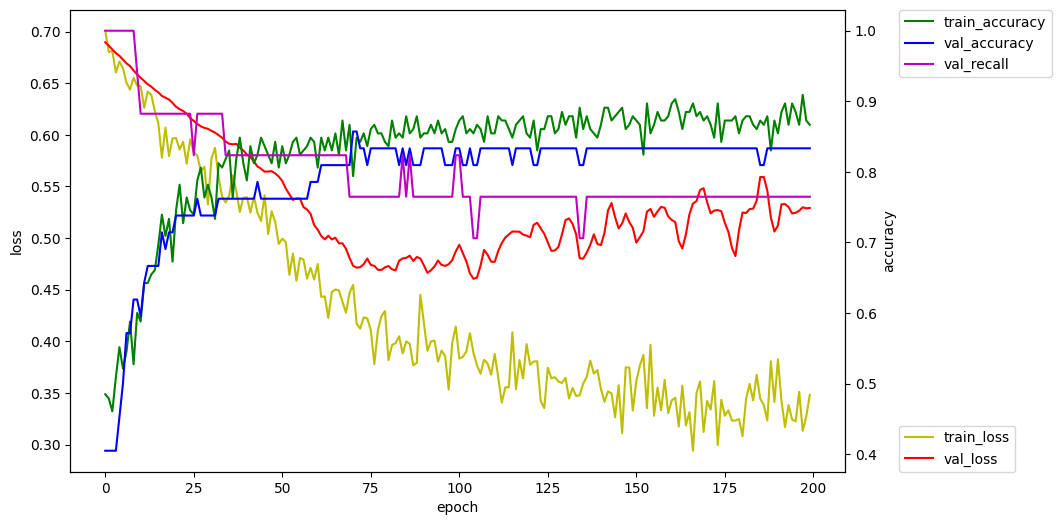

In [78]:
# 학습과정 표시하기

fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')

acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
acc_ax.plot(hist.history['val_recall_5'], 'm', label='val_recall')


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(bbox_to_anchor=(1.07, 0.1), loc=2, borderaxespad=0.)
acc_ax.legend(bbox_to_anchor=(1.07, 1), loc=2, borderaxespad=0.)
plt.show()

In [79]:
score = model.evaluate(X_test, y_test, verbose=0)
print('model loss:', score[0])
print('model accuracy:', score[1])
print('model precision:', score[2])
print('model recall:', score[3])

model loss: 0.6022153496742249
model accuracy: 0.8089887499809265
model precision: 0.7857142686843872
model recall: 0.8048780560493469


In [101]:
# 교차표(혼돈행렬) 
 
y_hat = (model.predict(X_test) >= 0.5).astype(int).reshape(-1)

3/3 [==============================] - 0s 2ms/step


In [99]:
confusion_matrix(y_test, y_hat)

array([[39,  9],
       [ 8, 33]], dtype=int64)

In [155]:
# 모델 사용

scaler.inverse_transform(X_test)[1]

array([ 35.,   1.,   4., 126., 282.,   0.,   2., 156.,   1.,   0.,   1.,
         0.,   7.])

In [156]:
(model.predict([[57. ,   1. ,   4. , 150. , 276. ,   0. ,   2. , 112. ,   1. , 0.6,   2. ,   1. ,   6. ],
               [ 35.,   1.,   4., 126., 282.,   0.,   2., 156.,   1.,   0.,   1., 0.,   7.]]) > 0.5).astype(int)

1/1 [==============================] - 0s 59ms/step


array([[1, 0],
       [1, 0]])

# 분류분석

- X_train, y_train, X_test, y_test를 사용<br> → y_train과 y_test 원핫인코딩

## 1. 데이터 셋 생성 & 전처리

In [107]:
dataset = df.values
dataset

array([[63.,  1.,  1., ...,  0.,  6.,  0.],
       [67.,  1.,  4., ...,  3.,  3.,  1.],
       [37.,  1.,  3., ...,  0.,  3.,  0.],
       ...,
       [68.,  1.,  4., ...,  2.,  7.,  1.],
       [57.,  1.,  4., ...,  1.,  7.,  1.],
       [57.,  0.,  2., ...,  1.,  3.,  1.]])

In [108]:
# 입력변수 X의 스케일 조정

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
scaled_X[0]

array([0.70833333, 1.        , 0.        , 0.48113208, 0.24429224,
       1.        , 1.        , 0.60305344, 0.        , 0.37096774,
       1.        , 0.        , 0.75      ])

In [112]:
# scaled_X, y를 학습데이터셋 : 테스트데이터셋 = 7:3으로 분할

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                    test_size=0.3,  # 테스트셋의 비율. 기본 0.25
                                                    random_state=7, # 시드값 맞추기
                                                    stratify=y) # 층화추출. y의 0,1기준으로 나눔

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((207, 13), (89, 13), (207, 1), (89, 1))

In [121]:
# 분류분석을 위한 타겟변수의 원핫 인코딩

Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

Y_train.shape, Y_test.shape

((207, 2), (89, 2))

## 2. 모델 생성(입력 13개, 출력1개) & 학습과정 설정 & 학습

- 모델 : 13 → 32 → 16 → 8 → 1
- 그래프를 보고 과적합이 심하면 줄이기를 추가할 수 있음

In [143]:
model = Sequential()
model.add(Input(shape=(13,)))
model.add(Dense(units=32, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 32)                448       
                                                                 
 dropout_26 (Dropout)        (None, 32)                0         
                                                                 
 dense_50 (Dense)            (None, 16)                528       
                                                                 
 dropout_27 (Dropout)        (None, 16)                0         
                                                                 
 dense_51 (Dense)            (None, 8)                 136       
                                                                 
 dropout_28 (Dropout)        (None, 8)                 0         
                                                                 
 dense_52 (Dense)            (None, 2)               

In [144]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

In [145]:
%%time
hist = model.fit(X_train, Y_train, epochs=250, validation_split=0.2, verbose=0)

CPU times: total: 16.8 s
Wall time: 12.5 s


## 3. 모델평가(그래프, 평가, 교차표) 

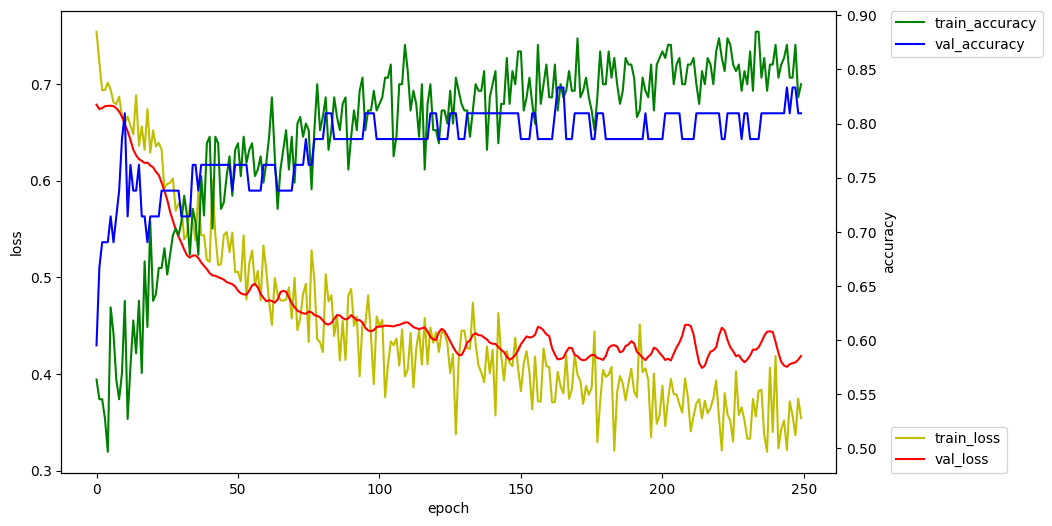

In [146]:
# 학습과정 표시하기

fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')

acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(bbox_to_anchor=(1.07, 0.1), loc=2, borderaxespad=0.)
acc_ax.legend(bbox_to_anchor=(1.07, 1), loc=2, borderaxespad=0.)
plt.show()

In [148]:
# 모델 평가

score = model.evaluate(X_test, Y_test, verbose=0)
print('model loss:', score[0])
print('model accuracy:', score[1])
print('model precision:', score[2])
print('model recall:', score[3])

model loss: 0.46292516589164734
model accuracy: 0.8089887499809265
model precision: 0.8089887499809265
model recall: 0.8089887499809265


In [150]:
# 교차표(혼돈행렬) 
 
y_hat = model.predict(X_test).argmax(axis=1)

3/3 [==============================] - 0s 2ms/step


In [151]:
confusion_matrix(y_test, y_hat)

array([[38, 10],
       [ 7, 34]], dtype=int64)